In [107]:
# Numerical analysis
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.nn import sigmoid

# Bayesian inference
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

# Dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set pseudo random number key
prng_key = random.PRNGKey(0)

# MODEL CONSTANTS
n_realizations = 5

# MCMC PARAMETERS
num_warmup = 500
num_samples = 1000
num_chains = 2

# TESTING
lams = [1/2, 1/10, 1/500, 1/10000]
sigma = 1
p = 1/2

In [108]:
# Load data file
dset = pd.read_csv("data/azdiabetes.csv", sep=",")

def standardize(x):
    return (x-x.mean(0)) / x.std(0)

y = dset["diabetes one-hot"].values
X = dset[["npreg", "glu", "bp", "skin", "bmi", "ped", "age"]].values

X = standardize(X)


<h2> Defining the Model </h2>

$$\begin{align*} 
y &\sim \text{Bernoulli}(X\gamma) \\

\gamma_j &= \sigma \left(\frac{L_j + \log\alpha_j}{\lambda}\right) \text{  for   } j = 1, ..., D \\
L_j &= \log (U_j) - \log (1-U_j)\\
U_j &\sim \text{Uniform}(0, 1)
\end{align*}$$




Note that in order for the model to work correctly, $\alpha_i$ must be  $\in (0, \infty)$.


In addition, the shrinkage coefficient $\kappa_i = 1 - \gamma_i$ is recorded.

In [109]:
def concrete_model(lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D])) 
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1 - U)) 
    alphas = jnp.zeros(X.shape[1])
    alphas += p / (1-p)
    
    gammas = numpyro.deterministic("gammas", sigmoid((L + jnp.log(alphas)) / lam)) 
    unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, 1))
    scaled_betas = numpyro.deterministic("betas", unscaled_betas*gammas)
    y_mean = jnp.dot(X, scaled_betas) 
    assert y_mean.shape == y.shape
    
    y = numpyro.sample("y", dist.Bernoulli(logits=y_mean), obs=y) 

In [110]:
def rebar_model(lam, X, y=None):
    '''
    Defines the Concrete random variable distribution.

    Parameters:
       real lam: temperature coefficient
       array alphas: parameter, Dx1
       array X: input data, NxD
       array y: output data, Nx1
    '''
    D = X.shape[1]
    U = numpyro.sample("U", dist.Uniform(0, 1).expand([D]))
    L = numpyro.deterministic("L", jnp.log(U) - jnp.log(1-U))
    
    k = (lam**2+lam+1) / (lam+1)
    numerator = (p/(1-p))**(1/k)
    denominator = 1 + (p/(1-p))**(1/k)
    alphas = jnp.zeros(X.shape[1])
    alphas += (numerator / denominator)

    T = numpyro.deterministic("T", jnp.log(alphas) - jnp.log(1-alphas))
    z_lam = numpyro.deterministic("z_lam", ((lam**2+lam+1)/(lam+1)) * T + L)

    gammas = numpyro.deterministic("gammas", sigmoid(z_lam/lam))
    unscaled_betas = numpyro.sample("unscaled_betas", dist.Normal(0, 1).expand([D]))
    scaled_betas = numpyro.deterministic("betas", unscaled_betas*gammas)

    y_mean = jnp.dot(X, scaled_betas)
    y = numpyro.sample("y", dist.Bernoulli(logits=y_mean), obs=y) 

In [111]:
def run_mcmc(model, prng_key, **kwargs):
    '''
    Run MCMC using the given model.

    Parameters:
       model: probabilistic model
       prng_key: random key 
       array y: observed data

    '''
    nuts = NUTS(model)
    mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
    mcmc.run(prng_key, **kwargs)
    return mcmc

In [112]:
def concrete(X, y, lam):
    '''
    Parameters:
       dict all_data: keys are integers and values are the corresponding tuple (X, Y)
       int lam: temperature coefficient
    
    Returns:
       arr mean_gammas: size (D,)
       dict samples: keys are sampled values in the mcmc model, values are the samples
       mcmc: a Numpyro MCMC object

    '''
    mcmc = run_mcmc(rebar_model, prng_key, lam = lam, X=X, y=y)
    samples = mcmc.get_samples()
    gammas =  samples["gammas"]
    betas = samples["betas"]
    return gammas, betas, samples, mcmc

<h1> Run and Evaluate MCMC </h1>

In [113]:
all_mses = dict()
mean_mses = dict()
all_betas = dict()
all_gammas = dict()
all_mcmc_runs = []
all_data = []

for _ in range(n_realizations):
    for lam in lams:
        gammas, betas, samples, mcmc = concrete(X, y, lam=lam)
        if lam not in all_gammas:
            all_gammas[lam] = []
        if lam not in all_betas:
            all_betas[lam] = []
        all_gammas[lam].append(gammas)
        all_betas[lam].append(betas)
        all_mcmc_runs.append(mcmc)
        all_data.append(samples)

/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_5655/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=2, progress_bar=True)
sample: 100%|██████████| 1500/1500 [00:00<00:00, 2676.40it/s, 31 steps of size 1.22e-01. acc. prob=0.92]
/var/folders/5v/22m3m0gx4zn571r9xrn6pcb80000gn/T/ipykernel_5655/2872204839.py:12: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available

The <a href=https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html>estimated effective sample size (ESS)</a> measures how much information is lost in MCMC due to correlation between different samples.

The <a href=https://arxiv.org/abs/1812.09384>Gelman-Rubin statistic</a> ($\hat{R}$) examines how well the chains have mixed. Common thresholds used include $1.01$, $1.05$, and $1.1$.

In [114]:
for mcmc in all_mcmc_runs:
    mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
             U[0]      0.61      0.22      0.60      0.34      1.00    884.11      1.00
             U[1]      0.75      0.15      0.76      0.54      1.00    737.33      1.00
             U[2]      0.29      0.23      0.22      0.00      0.66    990.52      1.00
             U[3]      0.30      0.25      0.24      0.00      0.71   1210.41      1.00
             U[4]      0.65      0.20      0.64      0.38      1.00   1064.70      1.00
             U[5]      0.64      0.20      0.62      0.38      1.00   1029.61      1.00
             U[6]      0.45      0.27      0.42      0.02      0.89    906.00      1.00
unscaled_betas[0]      0.71      0.48      0.59      0.15      1.52    908.66      1.00
unscaled_betas[1]      1.30      0.37      1.20      0.86      1.84    558.18      1.00
unscaled_betas[2]     -0.10      0.75     -0.10     -1.35      1.17   1104.51      1.00
unscaled_betas[3]      0.15    

<h1> Results </h1>

lam=0.1, 
 mean_unscaled_betas=array([ 0.4242631 ,  1.0697905 , -0.00804182,  0.01413142,  0.46259162,
        0.44684696,  0.11024358], dtype=float32), 
 mean_gammas=array([0.8830266 , 0.976042  , 0.13377224, 0.19000341, 0.88777006,
       0.89763945, 0.3584353 ], dtype=float32),  
 mean_scaled_betas=array([ 0.3746356 ,  1.0441604 , -0.00107577,  0.00268502,  0.410675  ,
        0.40110746,  0.03951519], dtype=float32)
lam=0.0001, 
 mean_unscaled_betas=array([ 0.37264654,  1.0825466 , -0.00999279, -0.00308572,  0.48388463,
        0.42234546,  0.16800259], dtype=float32), 
 mean_gammas=array([0.93099654, 1.        , 0.094     , 0.0775    , 0.9997717 ,
       1.        , 0.6324229 ], dtype=float32),  
 mean_scaled_betas=array([ 3.4693265e-01,  1.0825466e+00, -9.3932252e-04, -2.3914329e-04,
        4.8377416e-01,  4.2234546e-01,  1.0624869e-01], dtype=float32)


(-0.05, 1.05)

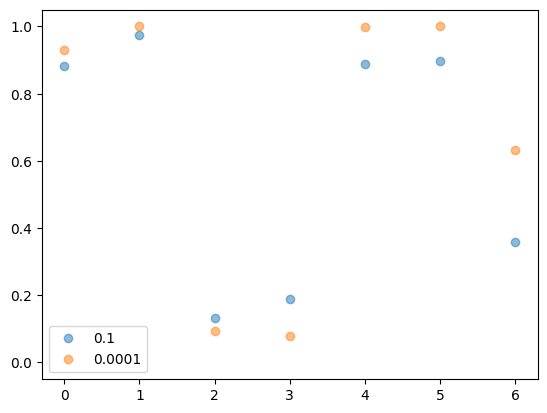

In [115]:
for lam in [0.1, 0.0001]: 
    mean_gammas = np.array(all_gammas[lam]).mean(0).mean(0)
    mean_unscaled_betas = np.array(all_betas[lam]).mean(0).mean(0)
    mean_scaled_betas = mean_gammas * mean_unscaled_betas
    plt.plot(mean_gammas, 'o', label=lam, alpha=0.5)
    print(f'{lam=}, \n {mean_unscaled_betas=}, \n {mean_gammas=},  \n {mean_scaled_betas=}')

plt.legend()
plt.ylim(-0.05, 1.05)

In [116]:
y = dict()
for i in range(7):
    y[i] = dict()

for lam in lams:
    mean_gammas[lam] = np.array(mean_gammas[lam])
    for i in range(7):
        y[i][lam] = np.ndarray.flatten(mean_gammas[lam][:, :, i])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Axes: ylabel='Density'>

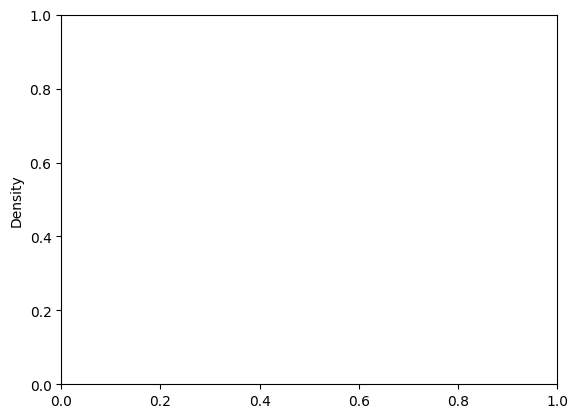

In [ ]:
sns.kdeplot(y[4][0.0001], warn_singular=False)

[0.5025514  0.6192577  0.33583632 ... 0.31396315 0.30416664 0.25696954] 0.5
[0.52366114 0.35518947 0.5488545  ... 0.60075897 0.62318385 0.5165107 ] 0.1
[0.39716494 0.5200908  0.44899255 ... 0.42513013 0.42513013 0.9809215 ] 0.002
[1. 1. 1. ... 1. 1. 1.] 0.0001


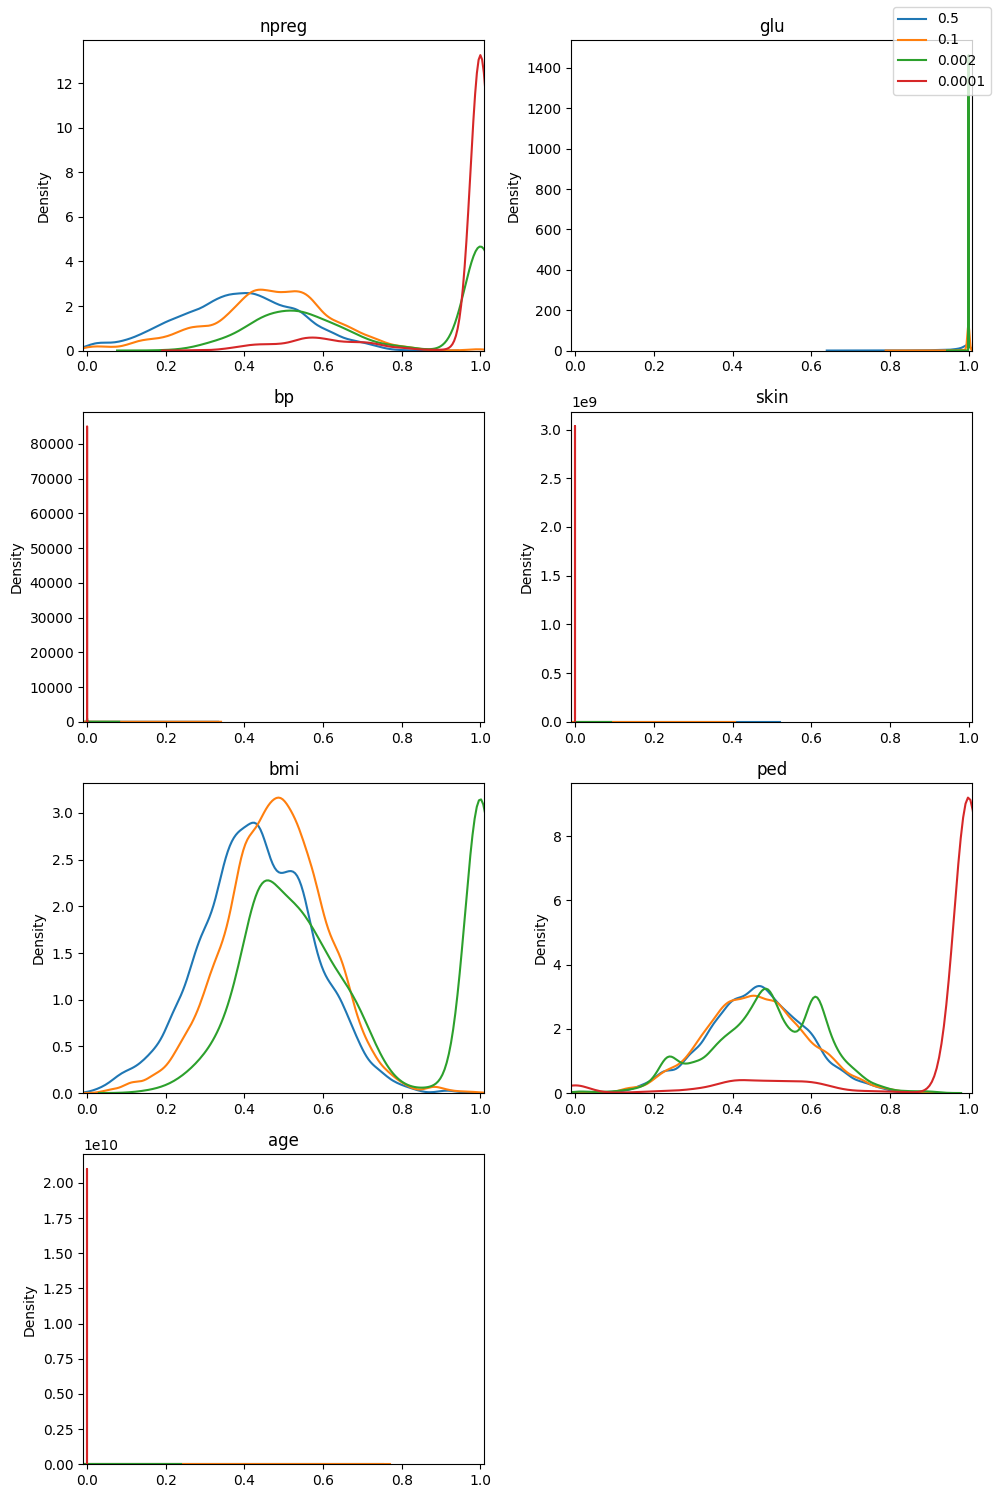

In [ ]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)

for lam in lams:
    sns.kdeplot(y[0][lam], ax=axs[0,0], label=f'{lam}', warn_singular=False)
    sns.kdeplot(y[1][lam], ax=axs[0,1], warn_singular=False)
    sns.kdeplot(y[2][lam], ax=axs[1,0], warn_singular=False)
    sns.kdeplot(y[3][lam], ax=axs[1,1], warn_singular=False)
    sns.kdeplot(y[4][lam], ax=axs[2,0], warn_singular=False)
    sns.kdeplot(y[5][lam], ax=axs[2,1], warn_singular=False)
    sns.kdeplot(y[6][lam], ax=axs[3,0], warn_singular=False)

for ax in axs.flat:
    ax.set_xlim(-0.01, 1.01)

axs[0,0].set_title("npreg")
axs[0,1].set_title("glu")
axs[1,0].set_title("bp")
axs[1,1].set_title("skin")
axs[2,0].set_title("bmi")
axs[2,1].set_title("ped")
axs[3,0].set_title("age")

plt.tight_layout()
fig.delaxes(axs[3, 1]) # deletes unused 8th subplot
fig.legend()